In [31]:
import pandas as pd
import pylab as plt 
import seaborn as sns
import numpy as np
from math import sqrt
from matplotlib import pyplot as plt
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function Definition

In [32]:
# The p_value is returned to verify Stationarity
def p_value(df_value):
    result = adfuller(df_value.dropna())
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [33]:
# Corelation and Differencing Plots 1.
def Differencing_Plot(df_value):  
    
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    axes[0, 0].plot(df_value)
    axes[0, 0].set_title('Original Series')
    plot_acf(df_value, ax=axes[0, 1])

    axes[1, 0].plot(df_value.diff())
    axes[1, 0].set_title('1st Order Differencing')
    plot_acf(df_value.diff().dropna(), ax=axes[1, 1])

    fig.tight_layout()
    return plt.show()

In [34]:
def Model_Creation(parTrain, parMax_p, parMax_q, parSeasonal):
    model = auto_arima(   parTrain,
                          start_p = 0,
                          start_q = 0,
                          information_criterion = 'aic',
                          test = 'adf',
                          max_p = parMax_p,
                          max_q = parMax_q,
                          D = 1,
                          start_P = 0,
                          m = 12,
                          seasonal = parSeasonal,
                          trace = True,
                          error_action = "ignore",
                          suppress_warnings = True,
                          stepwise = True,
                          verbose = 1)
    return model.summary()

In [35]:
# Dynamic function to divide Dataset into testing and training set 
def Dynamic_Splitting (parDf,parColumn,parTrainSize):
    
    # Test e Train DataSet creation
    train_size = parTrainSize
    Df = parDf
    col = parColumn
    split_idx = round(len(Df[col])* train_size)

    # Split
    train = Df.iloc[:split_idx]
    test = Df.iloc[split_idx:]
    

    # Visualize split
    fig,ax= plt.subplots(figsize=(10,10))
    kws = dict(marker='o')
    plt.plot(train, label='Train', **kws)
    plt.plot(test, label='Test', **kws)
    ax.legend(bbox_to_anchor=[1,1]);
    
    return train, test

In [36]:
# Allows you to perform the study using SARIMAX
# Moreover a what if analysis between test data and prediction is introduced 
# A1: First element for the order of arima
# A2: Second element for the order of arima
# A3: Third element for the order of arima
# S1: First element for Sarima's order
# S2: Second element for Sarima's order
# S3: Third element for the order of Sarima

def Sarimax_Execution(parTrain,parTest,parColumn,parSteps,A1,A2,A3,S1,S2,S3,parSeason):
  
    # Model Built
    model = SARIMAX(parTrain, order=(A1,A2,A3), seasonal_order=(S1,S2,S3,parSeason))
    
    # Fitting model
    results = model.fit()
    
    # Plot parameters
    plt.rcParams['figure.figsize'] = 12, 8
    plot = results.plot_diagnostics()

    # SARIMA - Prevision with Confidence Intervall
    forecast = results.get_forecast(steps = parSteps)
    lower = forecast.conf_int()["lower " + parColumn]
    upper = forecast.conf_int()["upper " + parColumn]
    fig,ax = plt.subplots(1,1,figsize=(20,10))

    plt.plot(parTrain, label='original',c='b')
    plt.plot(forecast.predicted_mean, label='SARIMAX', c="g")
    plt.plot(parTest, label='test',color='orange')
    plt.fill_between(forecast.conf_int().index,lower,upper,color='lightgray')
    plt.xlabel('Date')
    plt.ylabel('No of activated conracts')
    plt.legend()
    plt.show()

    return forecast

# Milano Hirings

## Creation of the New DataSet for Time Serie

In [37]:
Hirings = pd.read_csv('Hiring_Computer_Science_Milano.csv')

In [38]:
Hirings_Milano = Hirings.copy()

In [39]:
Hirings_Milano.head(5)

,DATA,SETTOREECONOMICO,ATTIVATO
0,2009-04-09,Tecnologie Informatiche,1
1,2009-04-10,Tecnologie Informatiche,1
2,2009-06-05,Tecnologie Informatiche,5
3,2009-06-06,Tecnologie Informatiche,1
4,2009-06-07,Tecnologie Informatiche,1


## Changing Columns Type

In [40]:
Hirings_Milano['DATA'] = pd.to_datetime(Hirings_Milano['DATA'])

In [41]:
Hirings_Milano.dtypes

DATA                datetime64[ns]
SETTOREECONOMICO            object
ATTIVATO                     int64
dtype: object

In [42]:
Hirings_Milano.head()

,DATA,SETTOREECONOMICO,ATTIVATO
0,2009-04-09,Tecnologie Informatiche,1
1,2009-04-10,Tecnologie Informatiche,1
2,2009-06-05,Tecnologie Informatiche,5
3,2009-06-06,Tecnologie Informatiche,1
4,2009-06-07,Tecnologie Informatiche,1


## Rebuilding of the DataSet

In [43]:
Hirings_Milano.head()

,DATA,SETTOREECONOMICO,ATTIVATO
0,2009-04-09,Tecnologie Informatiche,1
1,2009-04-10,Tecnologie Informatiche,1
2,2009-06-05,Tecnologie Informatiche,5
3,2009-06-06,Tecnologie Informatiche,1
4,2009-06-07,Tecnologie Informatiche,1


In [44]:
Hirings_Milano = Hirings_Milano.groupby(pd.Grouper(key='DATA', axis=0, freq='M')).mean(numeric_only = True)

In [45]:
Hirings_Milano['ATTIVATO'] = Hirings_Milano['ATTIVATO'].ffill()

In [46]:
Hirings_Milano.head()

,ATTIVATO
DATA,
2009-04-30,1.000
2009-05-31,1.000
2009-06-30,10.250
2009-07-31,18.000
2009-08-31,13.125


In [47]:
#Hirings_Milano['ATTIVATO'].isnull().sum()

In [48]:
Hirings_Milano.shape

(151, 1)

# Time Series

<AxesSubplot:xlabel='DATA'>

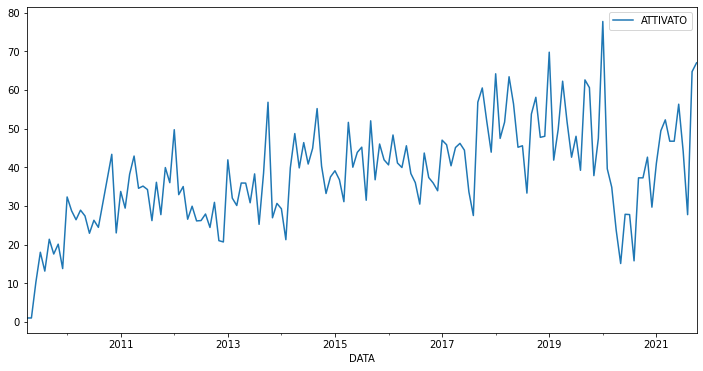

In [49]:
Hirings_Milano.plot(figsize=(12,6))

## Seasonality

Seasonality in time-series data refers to a pattern that occurs at a regular interval. 

### Multiplicative Seasonal Decompose

Multiplicative seasonality is not appropriate for zero and negative values

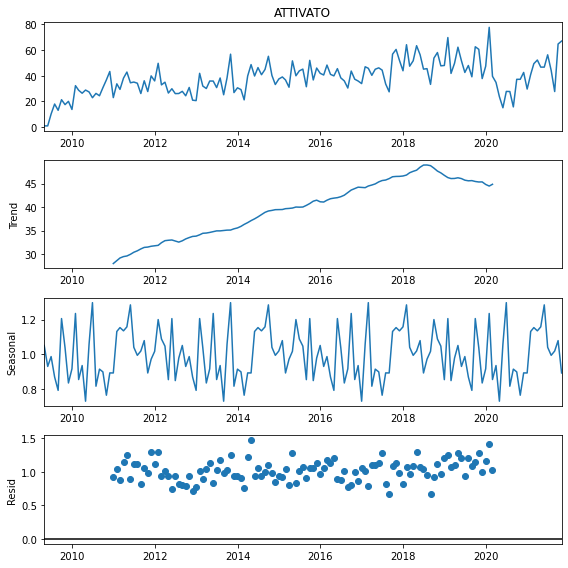

In [50]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_mult = seasonal_decompose(Hirings_Milano['ATTIVATO'], model = 'multiplicative', period = 40)
decomposition_result = result_mult.plot()

### Additive Seasonal Decompose

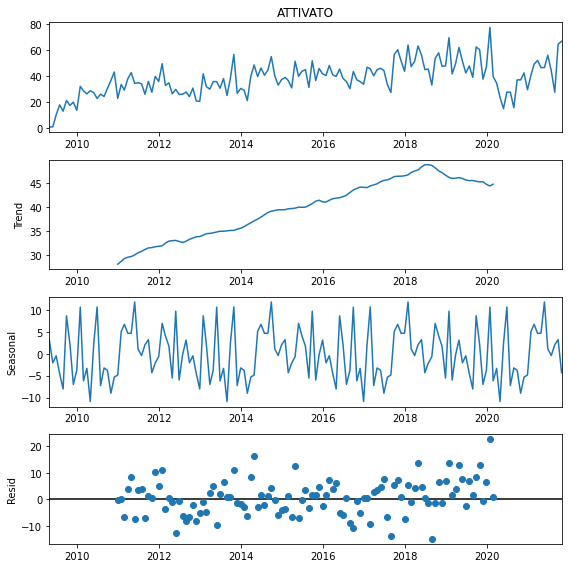

In [51]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_add = seasonal_decompose(Hirings_Milano['ATTIVATO'], model = 'additive', period = 40)
decomposition_result = result_add.plot()

## Stationarity

A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. This Means that Mean, variance and other statistics of a stationary time series remains constant.
The p-value represents a probability of the error when expecting, that the trend differs from zero. Returning p_value to verify Stationarity.

In [52]:
# ADF calculation
p_value(Hirings_Milano["ATTIVATO"])

ADF Statistic: -1.966977
p-value: 0.301237


### Differencing

Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) Trend and Seasonality.

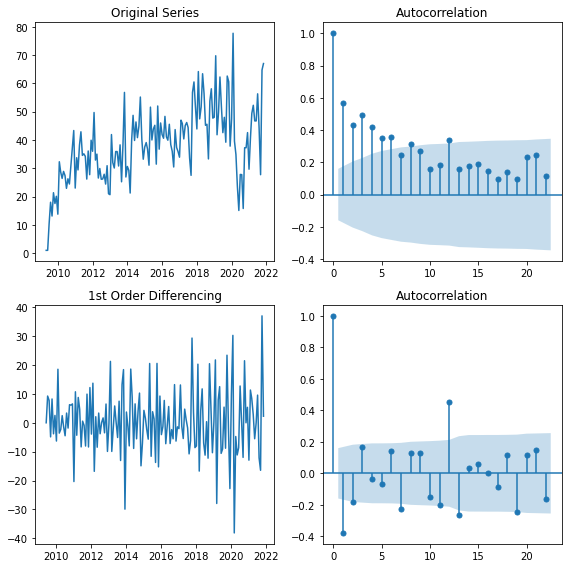

In [53]:
# Differencing plots representation
Differencing_Plot(Hirings_Milano["ATTIVATO"])

In [54]:
# Time Serie Stationarity Verification (If p_value < 0.05)
p_value(Hirings_Milano["ATTIVATO"].diff())

ADF Statistic: -4.219804
p-value: 0.000610


## Training and Testing Dataset

In this section Training and Testing Dataset are generated with the Dynamic Function "Dynamic_Splitting"

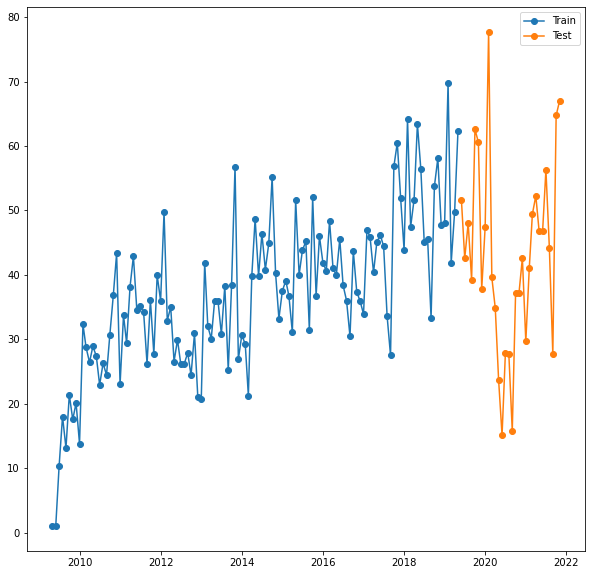

In [55]:
train, test = Dynamic_Splitting(Hirings_Milano,"ATTIVATO",0.80)

## SARIMAX Model Implementation

In order to implement the Sarimax prediction model, it's necessary to find out the optimal model. For this reason, the function "Model_Creation" permits to discover the best configuration.

In [56]:
Model_Creation(train,6,6,True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=798.413, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=821.391, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=797.242, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=767.728, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=791.344, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.43 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=783.386, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.55 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=768.751, Time=0.17 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=768.805, Time=0.13 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=780.200, Time=0.09 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=769.950, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=768.969, Time=0.12 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]        

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  121
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -380.864
Date:                            Thu, 18 Aug 2022   AIC                            767.728
Time:                                    17:44:25   BIC                            775.774
Sample:                                         0   HQIC                           770.991
                                            - 121                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6695      0.076     -8.865      0.000      -0.818      -0.521
ma.S.L12      -0.7647      0.114     -6.712      0.000      -0.988      -0.541
sigma2        61.0925     10.328      5.915      0.000      40.849      81.336
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 1.17
Prob(Q):                              0.71   Prob(JB):                         0.56
Heteroskedasticity (H):               0.95   Skew:                             0.15
Prob(H) (two-sided):                  0.87   Kurtosis:                         2.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Alessandro\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


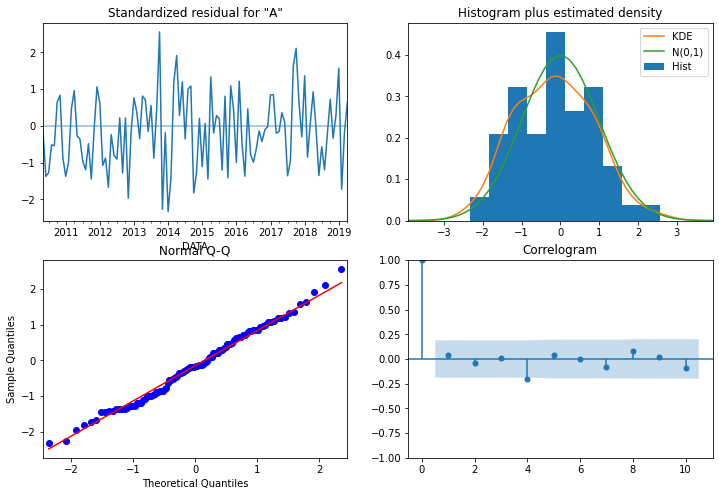

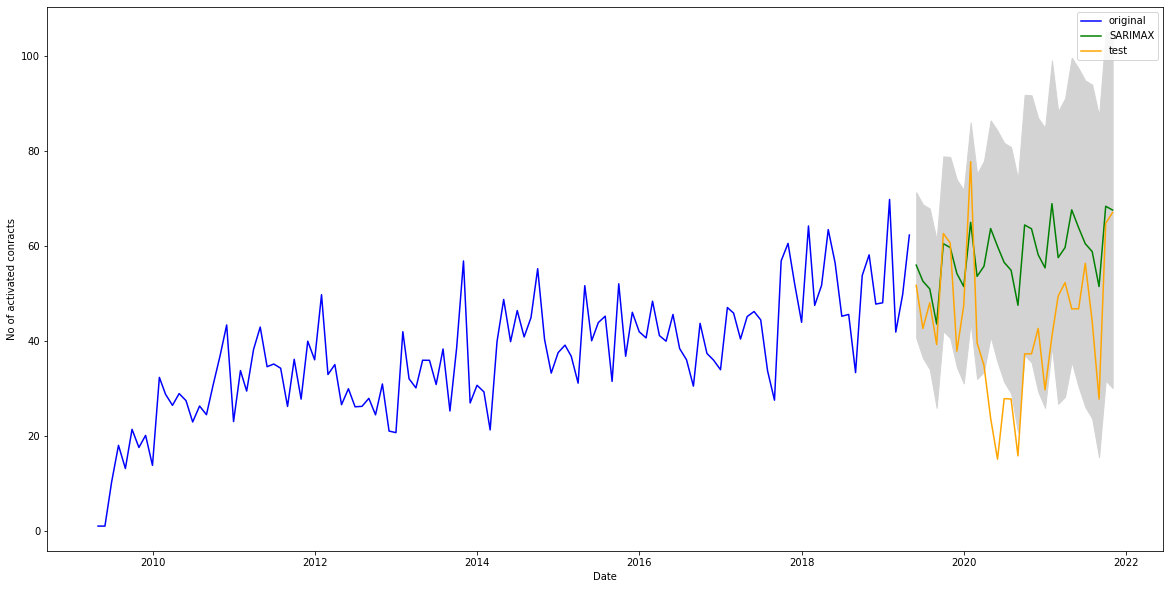

In [59]:
# Numeric values represent:
# First: Number of Test Data
# Middle: the best SARIMAX model returned in the previous Cell
# Last: Periodicity

sarima_prediction = Sarimax_Execution(train,test,"ATTIVATO",30,0,1,1,0,1,1,12)

In [60]:
# Metrics of Sarima Evaluation
rmse = sqrt(mean_squared_error(test,sarima_prediction.predicted_mean))
print('RMSE: %f' % rmse)

RMSE: 20.118628


## LSTM Forecasting

LSTM allows to predict the future values of a Time Serie adopting a Deep Learning approach

Before to start Training and Testing data are scaled. Here the minimum value n the dataset is subtracted of the features, then the elements into the dataset are divided from the Range (Max Value - Min Value) 

In [29]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [30]:
Hirings_Milano.head(), Hirings_Milano.tail()

(            ATTIVATO
 DATA                
 2009-04-30     1.000
 2009-05-31     1.000
 2009-06-30    10.250
 2009-07-31    18.000
 2009-08-31    13.125,
              ATTIVATO
 DATA                 
 2021-06-30  56.300000
 2021-07-31  44.166667
 2021-08-31  27.727273
 2021-09-30  64.727273
 2021-10-31  67.000000)

In [31]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [32]:
scaled_train[:15]

array([[0.        ],
       [0.        ],
       [0.13454545],
       [0.24727273],
       [0.17636364],
       [0.29619835],
       [0.24066116],
       [0.27768595],
       [0.18585859],
       [0.45527273],
       [0.40330579],
       [0.36969697],
       [0.40565657],
       [0.384     ],
       [0.31867769]])

Elements contained in the 2 datasets are related in proportion to their value.

In [33]:
# Generator Definition for 12 month
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [34]:
X,y = generator[0]
print(f'Array: \n{X.flatten()}')
print(f'Prediction: \n{y}')

Array: 
[0.         0.         0.13454545 0.24727273 0.17636364 0.29619835
 0.24066116 0.27768595 0.18585859 0.45527273 0.40330579 0.36969697]
Prediction: 
[[0.40565657]]


In [35]:
X.shape  #N_Rows, N_Columns, N_Features

(1, 12, 1)

## LSTM Model Implementation

At this point the LSTM model can be defined. Activation and Loss Functions are required, where the first has 'tanh' as default value, but in this case ReLU function is preferred to guarantee better quality to the neural unit (bounded, monotony, easy to handle)   

In [36]:
# Model Definition
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(generator, epochs = 200)  #Epochs = Number of Iterations

Epoch 1/200
109/109 [==============================] - 1s 4ms/step - loss: 0.0323
Epoch 2/200
109/109 [==============================] - 0s 4ms/step - loss: 0.0165
Epoch 3/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0156
Epoch 4/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 5/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0157
Epoch 6/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0166
Epoch 7/200
109/109 [==============================] - 0s 4ms/step - loss: 0.0159
Epoch 8/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0175
Epoch 9/200
109/109 [==============================] - 0s 4ms/step - loss: 0.0148
Epoch 10/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 11/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0161
Epoch 12/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0153
Epoch 13/200


109/109 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 197/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0113
Epoch 198/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0115
Epoch 199/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0110
Epoch 200/200
109/109 [==============================] - 0s 3ms/step - loss: 0.0109


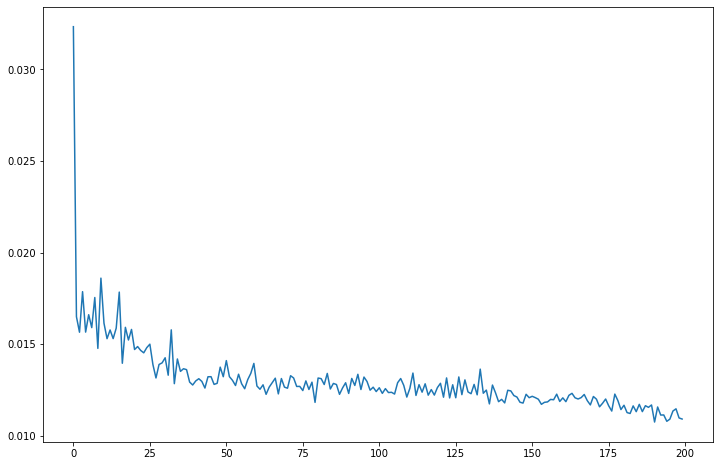

In [39]:
# Plot to analize value loss during epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [40]:
last_train_batch = scaled_train[-12:]

In [41]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [42]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 148ms/step


array([[0.7588903]], dtype=float32)

In [43]:
scaled_test[0]

array([0.7369697])

In [44]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # Prediction value for First Batch
    current_prediction = model.predict(current_batch)[0] 
    # Append Prediction into the array
    test_predictions.append(current_prediction)          
    # Using Prediction to update batch, removing the first value 
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 16ms/step


In [45]:
test_predictions

[array([0.7588903], dtype=float32),
 array([0.71925807], dtype=float32),
 array([0.710418], dtype=float32),
 array([0.5939107], dtype=float32),
 array([0.74102676], dtype=float32),
 array([0.78715086], dtype=float32),
 array([0.6693691], dtype=float32),
 array([0.6703106], dtype=float32),
 array([1.011345], dtype=float32),
 array([0.7381307], dtype=float32),
 array([0.73450816], dtype=float32),
 array([0.864576], dtype=float32),
 array([0.74189425], dtype=float32),
 array([0.7336432], dtype=float32),
 array([0.717765], dtype=float32),
 array([0.6922877], dtype=float32),
 array([0.7177042], dtype=float32),
 array([0.7508689], dtype=float32),
 array([0.6622368], dtype=float32),
 array([0.6566802], dtype=float32),
 array([1.0428356], dtype=float32),
 array([0.71395254], dtype=float32),
 array([0.74670815], dtype=float32),
 array([0.83327353], dtype=float32),
 array([0.7352791], dtype=float32),
 array([0.72977746], dtype=float32),
 array([0.7136451], dtype=float32),
 array([0.69157445], dt

In [46]:
test.head()

,ATTIVATO
DATA,
2019-05-31,51.666667
2019-06-30,42.583333
2019-07-31,48.000000
2019-08-31,39.200000
2019-09-30,62.583333


In [47]:
true_predictions = scaler.inverse_transform(test_predictions)

In [48]:
test['Predictions'] = true_predictions

C:\Users\ALESSA~1\AppData\Local\Temp/ipykernel_16708/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [49]:
test.head()

,ATTIVATO,Predictions
DATA,,
2019-05-31,51.666667,53.173706
2019-06-30,42.583333,50.448992
2019-07-31,48.000000,49.841237
2019-08-31,39.200000,41.831360
2019-09-30,62.583333,51.945590


<AxesSubplot:xlabel='DATA'>

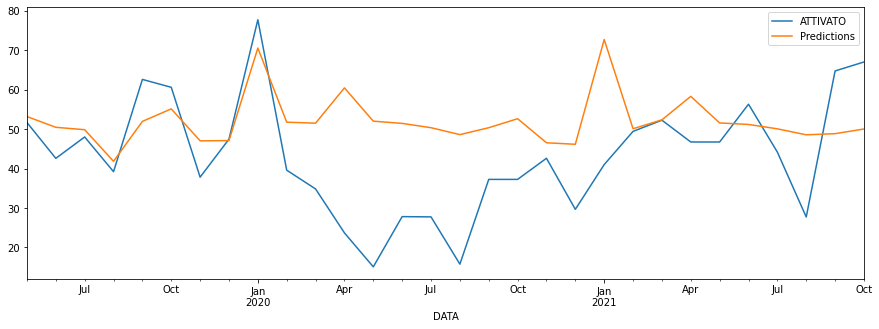

In [50]:
test.plot(figsize = (15,5))

In [51]:
rmse = sqrt(mean_squared_error(test['ATTIVATO'],test['Predictions']))
print(rmse)

16.86150367850763


# Milano Dismissals

## Creation of the New DataSet for Time Serie

In [54]:
Dismissals = pd.read_csv('Dismissal_Computer_Science_Milano.csv')

In [55]:
Dismissals_Milano = Dismissals.copy()

In [56]:
Dismissals_Milano.head(5)

,DATA,SETTOREECONOMICO,CESSATO
0,2009-04-01,Tecnologie Informatiche,1
1,2009-04-09,Tecnologie Informatiche,1
2,2009-06-05,Tecnologie Informatiche,2
3,2009-06-06,Tecnologie Informatiche,1
4,2009-06-08,Tecnologie Informatiche,9


## Changing Columns Type

In [57]:
Dismissals_Milano['DATA'] = pd.to_datetime(Dismissals_Milano['DATA'])

In [58]:
Dismissals_Milano.dtypes

DATA                datetime64[ns]
SETTOREECONOMICO            object
CESSATO                      int64
dtype: object

In [59]:
Dismissals_Milano.head()

,DATA,SETTOREECONOMICO,CESSATO
0,2009-04-01,Tecnologie Informatiche,1
1,2009-04-09,Tecnologie Informatiche,1
2,2009-06-05,Tecnologie Informatiche,2
3,2009-06-06,Tecnologie Informatiche,1
4,2009-06-08,Tecnologie Informatiche,9


## Rebuilding of the DataSet

In [60]:
Dismissals_Milano.head()

,DATA,SETTOREECONOMICO,CESSATO
0,2009-04-01,Tecnologie Informatiche,1
1,2009-04-09,Tecnologie Informatiche,1
2,2009-06-05,Tecnologie Informatiche,2
3,2009-06-06,Tecnologie Informatiche,1
4,2009-06-08,Tecnologie Informatiche,9


In [61]:
#Dismissals_Milano = Dismissals_Milano.groupby(pd.Grouper(key='DATA', axis=0, freq='M')).sum(numeric_only = True)
Dismissals_Milano = Dismissals_Milano.groupby(pd.Grouper(key='DATA', axis=0, freq='M')).mean(numeric_only = True)

In [62]:
Dismissals_Milano['CESSATO'] = Dismissals_Milano['CESSATO'].ffill()

In [63]:
Dismissals_Milano.head()

,CESSATO
DATA,
2009-04-30,1.000000
2009-05-31,1.000000
2009-06-30,5.428571
2009-07-31,11.800000
2009-08-31,12.625000


In [65]:
Dismissals_Milano.shape

(151, 1)

# Time Series

<AxesSubplot:xlabel='DATA'>

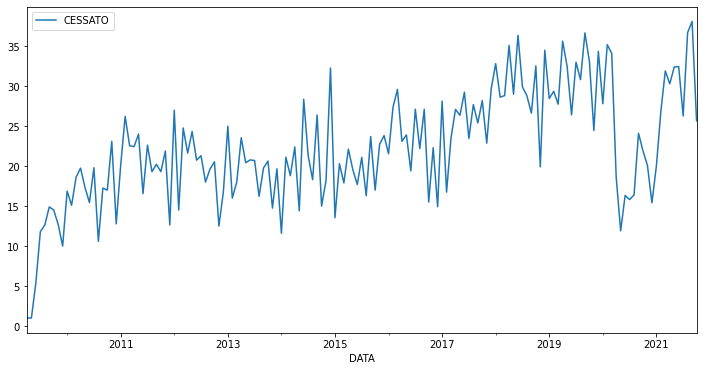

In [66]:
Dismissals_Milano.plot(figsize=(12,6))

## Seasonality

Seasonality in time-series data refers to a pattern that occurs at a regular interval. 

### Multiplicative Seasonal Decompose

Multiplicative seasonality is not appropriate for zero and negative values

In [ ]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_mult = seasonal_decompose(Dismissals_Milano['CESSATO'], model = 'multiplicative', period = 40)
decomposition_result = result_mult.plot()

### Additive Seasonal Decompose

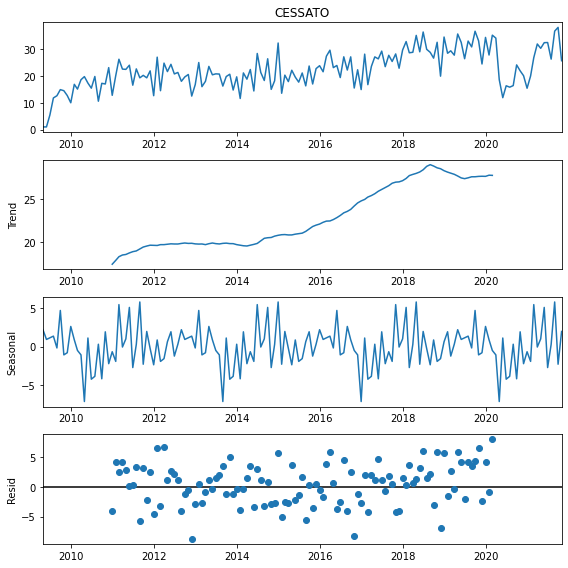

In [67]:
# Seasonal Variation Analyzing
plt.rcParams.update({'figure.figsize': (8,8)})
result_add = seasonal_decompose(Dismissals_Milano['CESSATO'], model = 'additive', period = 40)
decomposition_result = result_add.plot()

## Stationarity

A stationary time series is a series whose statistical properties are independent of the point in time at which they are observed. This Means that Mean, variance and other statistics of a stationary time series remains constant.
The p-value represents a probability of the error when expecting, that the trend differs from zero. Returning p_value to verify Stationarity.

In [69]:
# ADF calculation
p_value(Dismissals_Milano["CESSATO"])

ADF Statistic: -3.546411
p-value: 0.006872


### Differencing

Differencing can help stabilize the mean of the time series by removing changes in the level of a time series, and so eliminating (or reducing) Trend and Seasonality.

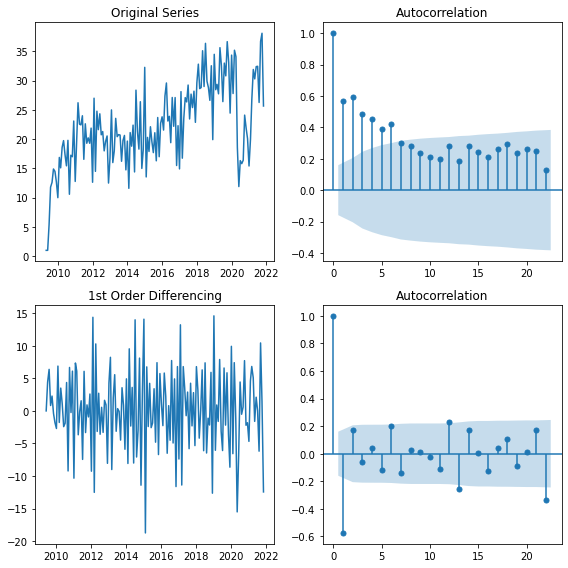

In [70]:
# Differencing plots representation
Differencing_Plot(Dismissals_Milano["CESSATO"])

In [71]:
# Time Serie Stationarity Verification (If p_value < 0.05)
p_value(Dismissals_Milano["CESSATO"].diff())

ADF Statistic: -8.156036
p-value: 0.000000


## Training and Testing Dataset

In this section Training and Testing Dataset are generated with the Dynamic Function "Dynamic_Splitting"

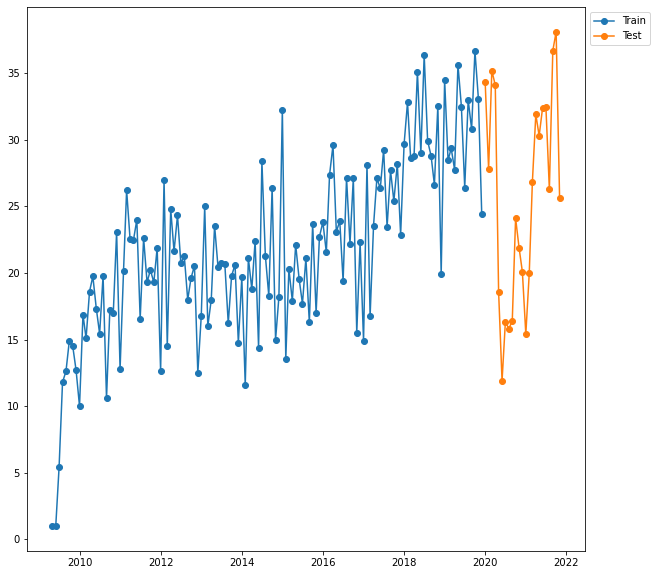

In [73]:
train, test = Dynamic_Splitting(Dismissals_Milano,"CESSATO",0.85)

## SARIMAX Model Implementation

In order to implement the Sarimax prediction model, it's necessary to find out the optimal model. For this reason, the function "Model_Creation" permits to discover the best configuration.

In [74]:
Model_Creation(train,6,6,True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=798.678, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=728.441, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=705.977, Time=0.13 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=727.693, Time=0.04 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.50 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=0.93 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=723.731, Time=0.17 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=695.060, Time=0.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=723.981, Time=0.04 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=0.51 sec
 ARIMA(1,1,1)(0,1,2)[12]             : AIC=inf, Time=0.85 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=713.448, Time=0.08 sec
 ARIMA(1,1,1)(1,1,2)[12]             : AIC=inf, Time=1.14

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  128
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -343.530
Date:                            Thu, 04 Aug 2022   AIC                            695.060
Time:                                    10:58:17   BIC                            706.040
Sample:                                         0   HQIC                           699.517
                                            - 128                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4381      0.106     -4.146      0.000      -0.645      -0.231
ma.L1         -0.5561      0.102     -5.443      0.000      -0.756      -0.356
ma.S.L12      -0.8309      0.128     -6.467      0.000      -1.083      -0.579
sigma2        20.2365      2.825      7.163      0.000      14.699      25.774
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):                 3.21
Prob(Q):                              0.70   Prob(JB):                         0.20
Heteroskedasticity (H):               0.85   Skew:                             0.26
Prob(H) (two-sided):                  0.61   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\Alessandro\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


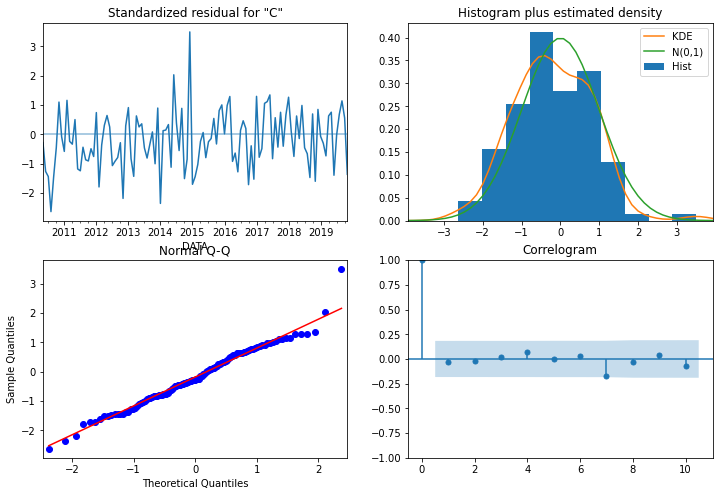

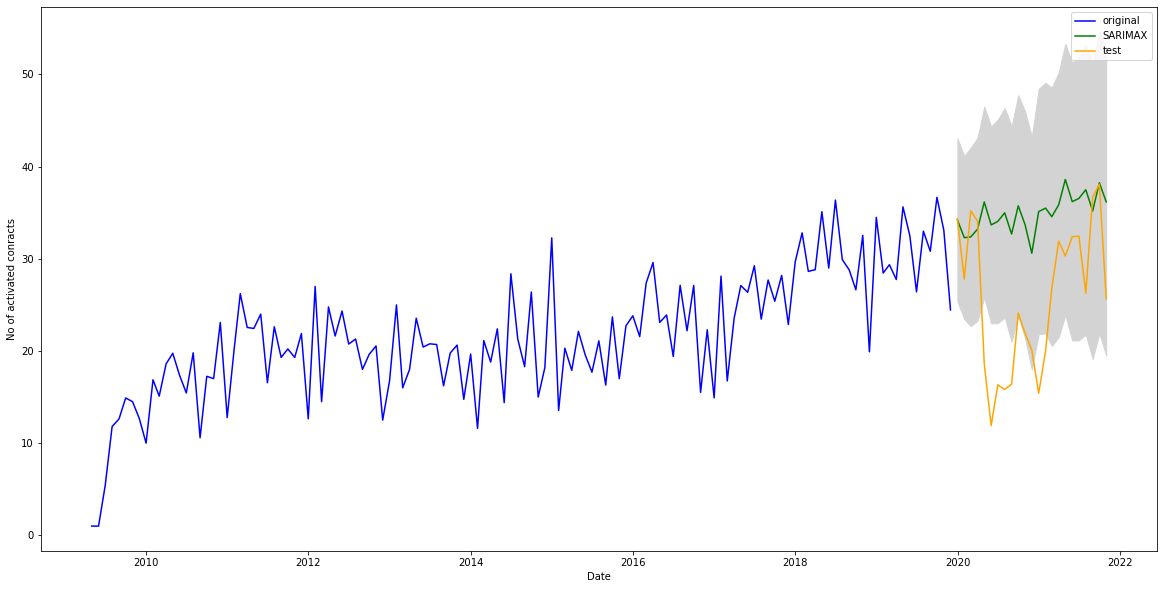

In [75]:
# Numeric values represent:
# First: Number of Test Data
# Middle: the best SARIMAX model returned in the previous Cell
# Last: Periodicity

sarima_prediction = Sarimax_Execution(train,test,"CESSATO",23,1,1,1,0,1,1,12)

In [76]:
# Metrics of Sarima Evaluation
rmse = sqrt(mean_squared_error(test,sarima_prediction.predicted_mean))
print('RMSE: %f' % rmse)

RMSE: 11.773095


## LSTM Forecasting

LSTM allows to predict the future values of a Time Serie adopting a Deep Learning approach

Before to start Training and Testing data are scaled. Here the minimum value n the dataset is subtracted of the features, then the elements into the dataset are divided from the Range (Max Value - Min Value) 

In [77]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [78]:
Dismissals_Milano.head(), Dismissals_Milano.tail()

(              CESSATO
 DATA                 
 2009-04-30   1.000000
 2009-05-31   1.000000
 2009-06-30   5.428571
 2009-07-31  11.800000
 2009-08-31  12.625000,
               CESSATO
 DATA                 
 2021-06-30  32.454545
 2021-07-31  26.272727
 2021-08-31  36.700000
 2021-09-30  38.100000
 2021-10-31  25.666667)

In [79]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [80]:
scaled_train[:15]

array([[0.        ],
       [0.        ],
       [0.12416555],
       [0.30280374],
       [0.32593458],
       [0.38971963],
       [0.37850467],
       [0.32803738],
       [0.25233645],
       [0.44509346],
       [0.3953271 ],
       [0.49345794],
       [0.52570093],
       [0.45794393],
       [0.40498442]])

Elements contained in the 2 datasets are related in proportion to their value.

In [81]:
# Generator Definition for 12 month
from keras.preprocessing.sequence import TimeseriesGenerator

n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length = n_input, batch_size = 1)

In [82]:
X,y = generator[0]
print(f'Array: \n{X.flatten()}')
print(f'Prediction: \n{y}')

Array: 
[0.         0.         0.12416555 0.30280374 0.32593458 0.38971963
 0.37850467 0.32803738 0.25233645 0.44509346 0.3953271  0.49345794]
Prediction: 
[[0.52570093]]


In [83]:
X.shape  #N_Rows, N_Columns, N_Features

(1, 12, 1)

## LSTM Model Implementation

At this point the LSTM model can be defined. Activation and Loss Functions are required, where the first has 'tanh' as default value, but in this case ReLU function is preferred to guarantee better quality to the neural unit (bounded, monotony, easy to handle)   

In [84]:
# Model Definition
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [85]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [86]:
model.fit(generator, epochs = 200)  #Epochs = Number of Iterations

Epoch 1/200
116/116 [==============================] - 1s 3ms/step - loss: 0.0470
Epoch 2/200
116/116 [==============================] - 0s 4ms/step - loss: 0.0176
Epoch 3/200
116/116 [==============================] - 0s 4ms/step - loss: 0.0185
Epoch 4/200
116/116 [==============================] - 0s 4ms/step - loss: 0.0219
Epoch 5/200
116/116 [==============================] - 0s 3ms/step - loss: 0.0168
Epoch 6/200
116/116 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 7/200
116/116 [==============================] - 0s 3ms/step - loss: 0.0172
Epoch 8/200
116/116 [==============================] - 0s 4ms/step - loss: 0.0175
Epoch 9/200
116/116 [==============================] - 0s 4ms/step - loss: 0.0171
Epoch 10/200
116/116 [==============================] - 0s 4ms/step - loss: 0.0179
Epoch 11/200
116/116 [==============================] - 0s 4ms/step - loss: 0.0172
Epoch 12/200
116/116 [==============================] - 0s 4ms/step - loss: 0.0184
Epoch 13/200


116/116 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 197/200
116/116 [==============================] - 0s 3ms/step - loss: 0.0121
Epoch 198/200
116/116 [==============================] - 0s 3ms/step - loss: 0.0116
Epoch 199/200
116/116 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 200/200
116/116 [==============================] - 0s 3ms/step - loss: 0.0123


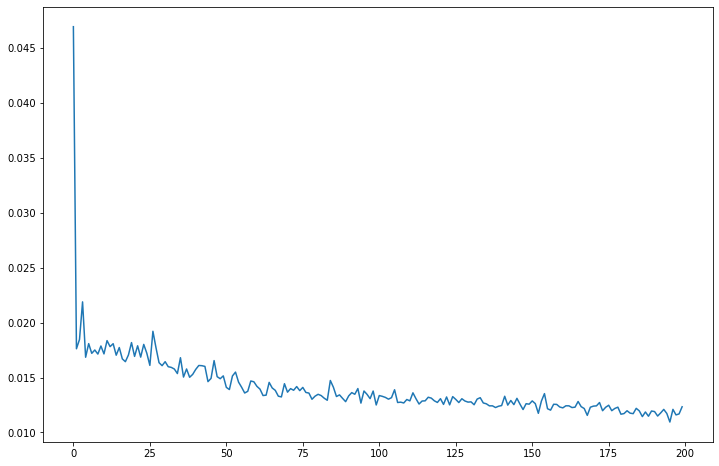

In [87]:
# Plot to analize value loss during epochs
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [88]:
last_train_batch = scaled_train[-12:]

In [89]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

In [90]:
model.predict(last_train_batch)

1/1 [==============================] - 0s 120ms/step


array([[0.9476755]], dtype=float32)

In [91]:
scaled_test[0]

array([0.93542906])

In [92]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    # Prediction value for First Batch
    current_prediction = model.predict(current_batch)[0] 
    # Append Prediction into the array
    test_predictions.append(current_prediction)          
    # Using Prediction to update batch, removing the first value 
    current_batch = np.append(current_batch[:,1:,:], [[current_prediction]], axis = 1)

1/1 [==============================] - 0s 17ms/step


In [93]:
test_predictions

[array([0.9476755], dtype=float32),
 array([0.7666073], dtype=float32),
 array([0.8026014], dtype=float32),
 array([0.77632964], dtype=float32),
 array([0.8441897], dtype=float32),
 array([0.79534966], dtype=float32),
 array([0.7725335], dtype=float32),
 array([0.8279927], dtype=float32),
 array([0.7977989], dtype=float32),
 array([0.84858686], dtype=float32),
 array([0.80694103], dtype=float32),
 array([0.765139], dtype=float32),
 array([0.8523283], dtype=float32),
 array([0.7640869], dtype=float32),
 array([0.7937455], dtype=float32),
 array([0.7737496], dtype=float32),
 array([0.7913191], dtype=float32),
 array([0.76695645], dtype=float32),
 array([0.7675595], dtype=float32),
 array([0.77834606], dtype=float32),
 array([0.76605403], dtype=float32),
 array([0.7809072], dtype=float32),
 array([0.76313186], dtype=float32)]

In [94]:
test.head()

,CESSATO
DATA,
2019-12-31,34.363636
2020-01-31,27.800000
2020-02-29,35.200000
2020-03-31,34.100000
2020-04-30,18.600000


In [95]:
true_predictions = scaler.inverse_transform(test_predictions)

In [96]:
test['Predictions'] = true_predictions

C:\Users\ALESSA~1\AppData\Local\Temp/ipykernel_16708/4269337381.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [97]:
test.head()

,CESSATO,Predictions
DATA,,
2019-12-31,34.363636,34.800427
2020-01-31,27.800000,28.342326
2020-02-29,35.200000,29.626116
2020-03-31,34.100000,28.689090
2020-04-30,18.600000,31.109433


<AxesSubplot:xlabel='DATA'>

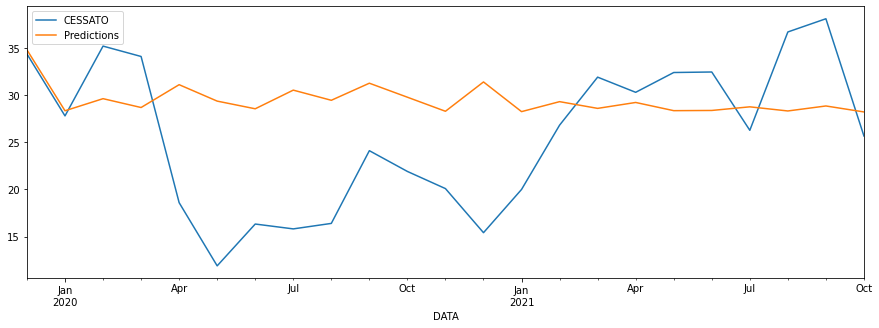

In [98]:
test.plot(figsize = (15,5))

In [99]:
rmse = sqrt(mean_squared_error(test['CESSATO'],test['Predictions']))
print(rmse)

8.803080112125269
